In this notebook, we will:

1. plot our data and make an anlysis.

2. check stationarity of the data

3. splitting our data and plotting training and testing data.

4. Conduct grid -search for optimalizing our model

5. initializing and fitting our model

6. Running model diagnostics and forecasting future values

Note: comprehensive analysis and explanations is given at each stage.

In [2]:
# importing libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm

In [ ]:
# uploading our dataset from a local directory
# paring the date column into a datetime index
df = pd.read_csv(r'../tochora/dd/Electric_Production.csv', parse_dates=['DATE'], index_col= 'DATE')
# display of the data
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


Note: pp values are collected monthly on every 1st day of the month.

In [ ]:
# renaming codename for electriciy production to Power production
df.rename(columns={"IPG2211A2N" : "Power_production"}, inplace=True)
df.head()

,Power_production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [ ]:
# shape of our dataset
df.shape

(397, 1)

our dataset has 397 rows and 1 column

In [ ]:
#checking null values
df.isnull().sum()

Power_production    0
dtype: int64

Our data is clean as it does not contain null values

In [ ]:
# statistics
df.describe()

,Power_production
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


The describe function gives a quick statistical analysis of the data where:

count = number of observations in our data in our case 397 units,    mean = average of values in the featured column that is 88.84 units,     std = 15.38, which shows standard deviation from the mean. 

our data has minimum value of 55.3 units while maximum value is 129.404 units . the rest are 25% = quartile deviation, 50% = median, 75% = upper quantile

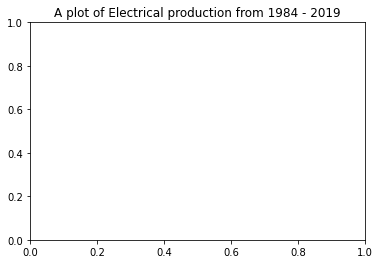

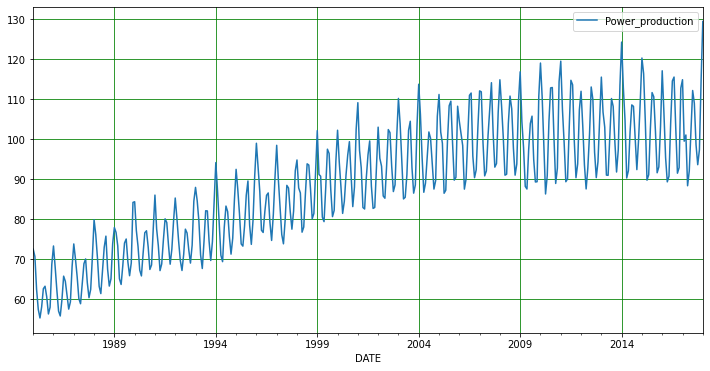

In [ ]:
plt.title("A plot of Electrical production from 1984 - 2019")
df.plot(kind = 'line', figsize=(12, 6))
plt.grid(color='green')

The plot above show a general increasing trend  in electricity production from 1984 to 2019. Electicity production was lowest around 1984  below 60 units while the peak was in 2014 slightly larger than 120 units.

we can decompose our data to check presence seasonal component using seasonal-decompose function from statsmodel package. We will use 12 periods since we have monthly data

Note: The are no huge variations in rolling variance thus we will assume an additive model.

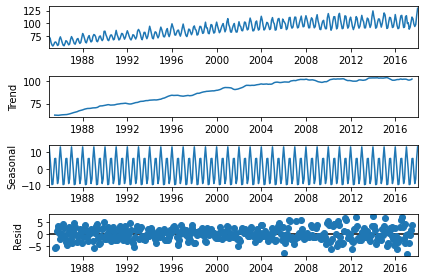

In [ ]:
# perform decomposition of our data
decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=12)
# extracting trend, seasonal and residual components from our dataset
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
#plotiing extracted components
decomposition.plot()
plt.show()

Stationarity

A time series is considered stationary if there isn't a systematic increase or decrease in mean and variance and where uch periodic changes have been removed otherwise it is non-stationary.

predictions are accurate when:

1. Both mean and variance is constant.

2. mean is constant but variance is not constant

Note: these conditions apply on non-stationary series if it is in weak sense.We can ue various methods to check stationarity of our timeeries

Rolling Statistics

it is used to plot the moving average or moving standard deviation to check whether it varies with time.The window input states the period used to take an average or standard deviation.

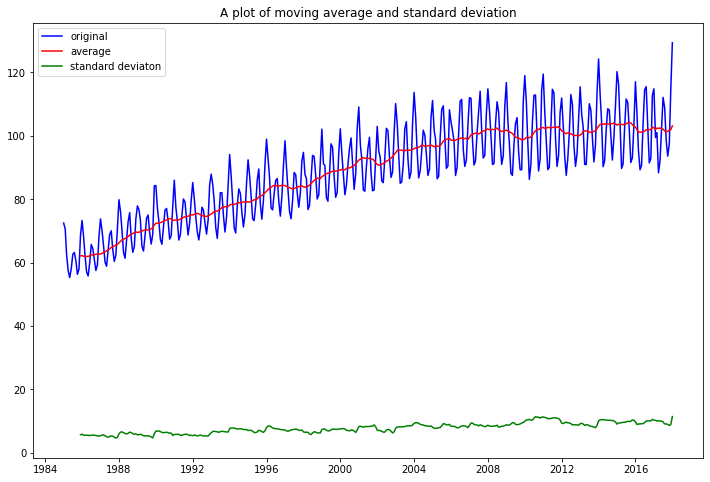

In [ ]:
# moving average of the data
rolling_mean = df.rolling(window=12).mean()
# moving variation of the data
rolling_std = df.rolling(window=12).std()
plt.figure(figsize = (12,8))
#plotiing the data
plt.plot(df, label='original', color='blue')
plt.plot(rolling_mean,label = 'average',color='red')
plt.plot(rolling_std, label = 'standard deviaton', color = 'green')
plt.title("A plot of moving average and standard deviation")
plt.legend(loc='best')

from the above plot, there is a rising trend of the rolling mean thus out timeseries is not stationary. Let us use another statistical test called dickey-fuller test.

Dickey-Fuller Test

Dickey fuller test is used to test whether a timeseries has a unit root. if a unit root is present then the timeseries is non-stationary but if it doesnt have it, then it is stationary. The formula for dickey fuller test is yt = ayt - U where a = alpha - 1, yt is a random walk and U is an error term.
In order to test stationarity, we take the hypothesis that if: p_value is less than a i.e 0.05 then our timeseries is stationary else it is non stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller
print("results of Dickey Fuller Test")
# using AIC which evaluates the strength of our model in penalising added parameters to it in order to fit data well
df_test = adfuller(df['Power_production'], autolag = "AIC")
# indexes to be analysed
df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p_value', 'number of lags', 'number of observations'])
# iterating each index with associated value
for key, value in df_test[4].items():
    df_output['Critical value (%s)'%key] = value
df_output

results of Dickey Fuller Test


Test Statistic             -2.256990
p_value                     0.186215
number of lags             15.000000
number of observations    381.000000
Critical value (1%)        -3.447631
Critical value (5%)        -2.869156
Critical value (10%)       -2.570827
dtype: float64

The p-value is 0.18862 thus our timeseries is not stationary as it is less greater than 0.05. Since we will use Sarima model which takes even seasonal components thus we wont make it stationary.

we will split data into training and testing data and then plot training and testing data. Training data will involve data from 1984-2016 while testing data from 2016-2018

Text(0, 0.5, 'maximum power_production')

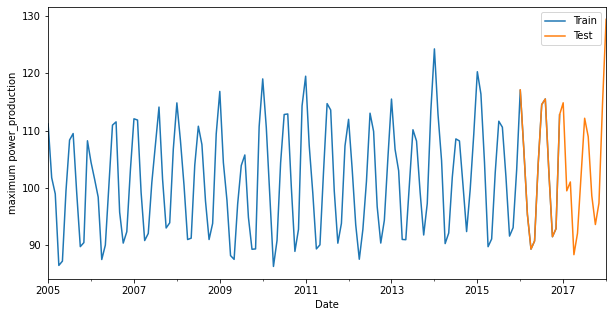

In [ ]:
# splitting data into training and testing data
df_train = df.loc[:'2016']
df_test = df.loc['2016':]
# plotting the last 12 years of our data
ax= df_train[-12 * 12:].plot(figsize = (10, 5))
df_test.plot(ax=ax)
plt.legend(['Train','Test'])
plt.xlabel('Date')
plt.ylabel('maximum power_production')

SARIMA Model

SARIMA model(Seasonal ARIMA) is just ARIMA model with a seasonal component added to it. ARIMA is used to forecast future values where it combines autoregressive(AR) and moving average(MA) to differencing to a non-stationary data. It has an order of p, d, q  where p=AR, d= order of differencing, q= MA.

SARIMA adds beside ARIMA components seasonal_AR, seasonal_MA, seasonal I terms which captures seasonal patterns in our data, thus the order of SARIMA is (p,d, q) (P,D,Q, m) where the capitalised letter represent seasonal components.

Note: m = seasonal peridicity of our data which is 12 months.

In order to have an optimal model we will use grid-search in order to develop a model that will not only be simple but also accurate.

In [ ]:
import itertools 
import math 
# assigning values to p,d,q, P, D, Q, m parameters
p_values = range(0, 3)
d_values = [0]
q_values = range(0, 3)
P_values = range(0, 2)
D_values = range(0, 1)
Q_values = range(0, 2)
m_values = [12]
# creating possible combinations of these perimeters
param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m_values))
#best aic # will learn about it later
best_aic = float("inf")
best_params = None
# performing grid-search
for i in param_combinations:
    order = i[:3]
    seasonal_order = i[3:]
    try:
        model = sm.tsa.SARIMAX(df_train, order=order, seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic 
        #ensuring convergence of our model by checking z_values that are not infinite
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)
    
            if aic < best_aic:
               best_aic = aic 
               best_params = i
        else:
            print(order, seasonal_order, 'not_converged')

    except:
        continue 
# printing best parameters
print("Best Parameters: ", best_params)
print("Best Aic: ", best_aic)

c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 0) (0, 0, 0, 12) 4544.4853767038385


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 0) (0, 0, 1, 12) 4070.7199345354493


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 0) (1, 0, 0, 12) 2147.342935303093


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 0) (1, 0, 1, 12) 2145.05735459139


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1) (0, 0, 0, 12) 4043.220734250487


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1) (0, 0, 1, 12) 3587.0806790421184


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 1) (1, 0, 0, 12) 1989.022978322314


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 1) (1, 0, 1, 12) 1972.9090521744201


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 2) (0, 0, 0, 12) 3637.8078998252718


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(0, 0, 2) (0, 0, 1, 12) 3207.7911243896306


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 2) (1, 0, 0, 12) 1973.8131853228601


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\te

(0, 0, 2) (1, 0, 1, 12) 1945.595513971357
(1, 0, 0) (0, 0, 0, 12) 2662.6944093634393


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 0) (0, 0, 1, 12) 2369.786071444368


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(1, 0, 0) (1, 0, 0, 12) 1944.5847704132118


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(1, 0, 0) (1, 0, 1, 12) 1848.1262566773014
(1, 0, 1) (0, 0, 0, 12) 2534.8571473038182


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 1) (0, 0, 1, 12) 2310.3995742204825


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(1, 0, 1) (1, 0, 0, 12) 1945.5670349353063


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(1, 0, 1) (1, 0, 1, 12) 1834.0801954289936


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 2) (0, 0, 0, 12) 2453.88141606737


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(1, 0, 2) (0, 0, 1, 12) 2208.3367095052745


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(1, 0, 2) (1, 0, 0, 12) 1901.0284850846958


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(1, 0, 2) (1, 0, 1, 12) 1789.7072587542664
(2, 0, 0) (0, 0, 0, 12) 2603.975525603314


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


(2, 0, 0) (0, 0, 1, 12) 2342.906486636739


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(2, 0, 0) (1, 0, 0, 12) 1946.2399618219383


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(2, 0, 0) (1, 0, 1, 12) 1842.5322590954017


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters

(2, 0, 1) (0, 0, 0, 12) 2535.069056999813


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters

(2, 0, 1) (0, 0, 1, 12) 2312.2570168237917


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters

(2, 0, 1) (1, 0, 0, 12) 1933.8011194774122


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters

(2, 0, 1) (1, 0, 1, 12) 1783.5892611752533
(2, 0, 2) (0, 0, 0, 12) 2420.0782812604134


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 2) (0, 0, 1, 12) 2188.957560779434


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(2, 0, 2) (1, 0, 0, 12) 1893.1527749630568


c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(2, 0, 2) (1, 0, 1, 12) 1781.1868237914973
Best Parameters:  (2, 0, 2, 1, 0, 1, 12)
Best Aic:  1781.1868237914973


In [ ]:
# training and fitting our SARIMA model
model = sm.tsa.SARIMAX(df_train, order=best_params[:3], seasonal_order=best_params[3:])
result = model.fit(disp=False)
# printing summary of our model
result.summary()

c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\test\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                   pp   No. Observations:                  384
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -883.593
Date:                              Mon, 17 Jul 2023   AIC                           1781.187
Time:                                      19:03:14   BIC                           1808.841
Sample:                                  01-01-1985   HQIC                          1792.156
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3497      0.100     13.548      0.000       1.154       1.545
ar.L2         -0.3507      0.099     -3.531      0.000      -0.545      -0.156
ma.L1         -0.7139      0.101     -7.099      0.000      -0.911      -0.517
ma.L2         -0.2157      0.089     -2.433      0.015      -0.389      -0.042
ar.S.L12       0.9953      0.004    258.625      0.000       0.988       1.003
ma.S.L12      -0.7401      0.038    -19.500      0.000      -0.815      -0.666
sigma2         5.2494      0.316     16.619      0.000       4.630       5.868
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                18.27
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.52   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The autoregressive terms (ar.L.1) and (ar.L.2) have estimated coefficients of 1.3497 and -0.3507 respectively.

The moving average term (ma.L.1) has an estimated coefficient of -0.7139.

The seasonal autoregressive term(ar.S.L12) has an estimated coefficient of 0.9953.

Log-likelihood is -883.593.This value is used to measure model performance in relation to other models. The higher value it is, the better the model. It is not helpful here since we don't have other models in this notebook

Akaike Information Criteria(AIC) is -1781.187.This is a metric that helps us to evaluate strength of our model by penalising the number of parameters added in a model to increase its max-likelihood thus finding a model with few parameters that fit data well. a lower value of AIC is the better one.

The "p > [z] " variable provides a value associated with each coefficient provided by our model.In our case, it is less than 0.05 significance level in all instances thus they are statistically significant

Plotting model diagnostics

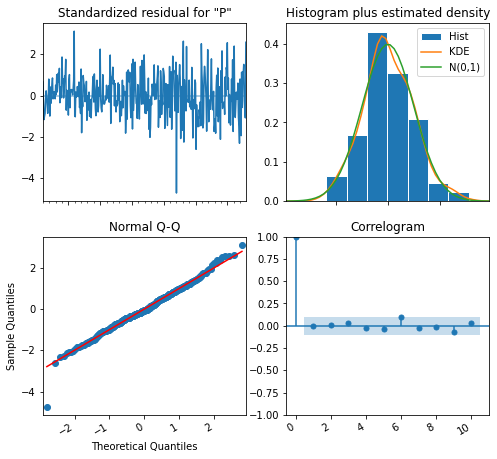

In [ ]:
#running model diagnostics
fig = result.plot_diagnostics(figsize=(8, 8))
fig.autofmt_xdate()
plt.show()

Model diagnostics summary

1. Standardized residual. It should be a random noise, with zero mean and a uniform variance. In our case, this requirement is met.

2. Histogram plus estimated density. It must look as a normal distribution which is already met in our case.

3. Normal Q-Q graph. Majority of the scatter plots must be lying in a straight line

4. correllogram. All lags must lie within the confidence band which is met case in our case.

Since all these conditions are met then our model is a good fit of our data

Making predictions aka Forecating future values

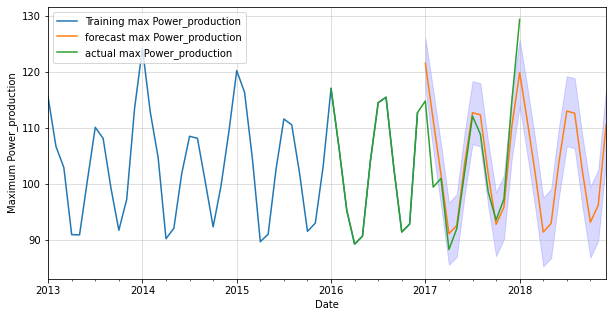

In [ ]:
# get forecasts and confidence itervals for two years
forecast = result.get_forecast(steps=24)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
# plotting the  forecast with training data
ax = df_train[-12 * 4:].plot(figsize=(10,5))
forecast_values.plot()
df_test.plot(ax=ax)
plt.fill_between(forecast_values.index, confidence_intervals['upper Power_production'], confidence_intervals['lower Power_production'],color='blue', alpha = 0.15)
plt.legend(['Training max Power_production', 'forecast max Power_production', 'actual max Power_production'], loc='upper left')
plt.xlabel('Date')
plt.ylabel('Maximum Power_production')
plt.grid(alpha=0.5)
plt.show()

well, our model not only plot future values but also the confidence intervals of the forecasted values.